In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse.linalg import svds
from sklearn.preprocessing import scale
import gc
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
%%time

train = pd.read_hdf('../input/X_train_add_supplement.h5', 'table')
test  = pd.read_hdf('../input/test_supplement.h5', 'table')

data = train.append(test)

CPU times: user 1min 33s, sys: 1min 40s, total: 3min 14s
Wall time: 1min 28s


In [3]:
drop_features = [
    'ip', 
    'day', 
    'click_time', 
    'click_id', 
    'minute',
    'second',
    'ip_day_hour_channel_count',
    'is_attributed'
]

categorical_features = [
    'app',
    'channel',
    'device',
    'hour',
    'os'
]

In [4]:
counts = data.drop(categorical_features + drop_features, axis=1)

In [5]:
feature_names = counts.columns

In [6]:
del train, test, data
gc.collect()

14

In [7]:
counts.dropna(axis=0, how='any', inplace=True)

In [8]:
mean = counts.values.mean(axis=0)
std  = counts.values.std(axis=0)

In [9]:
# scale
counts = (counts.values - mean) / std

In [10]:
%%time

x = counts.T @ counts / (counts.shape[0] - 1)
eigval, eigvec = np.linalg.eigh(x)

CPU times: user 18.5 s, sys: 26.3 ms, total: 18.6 s
Wall time: 3.31 s


In [11]:
eigval = eigval[::-1]
eigvec = eigvec[:, ::-1]

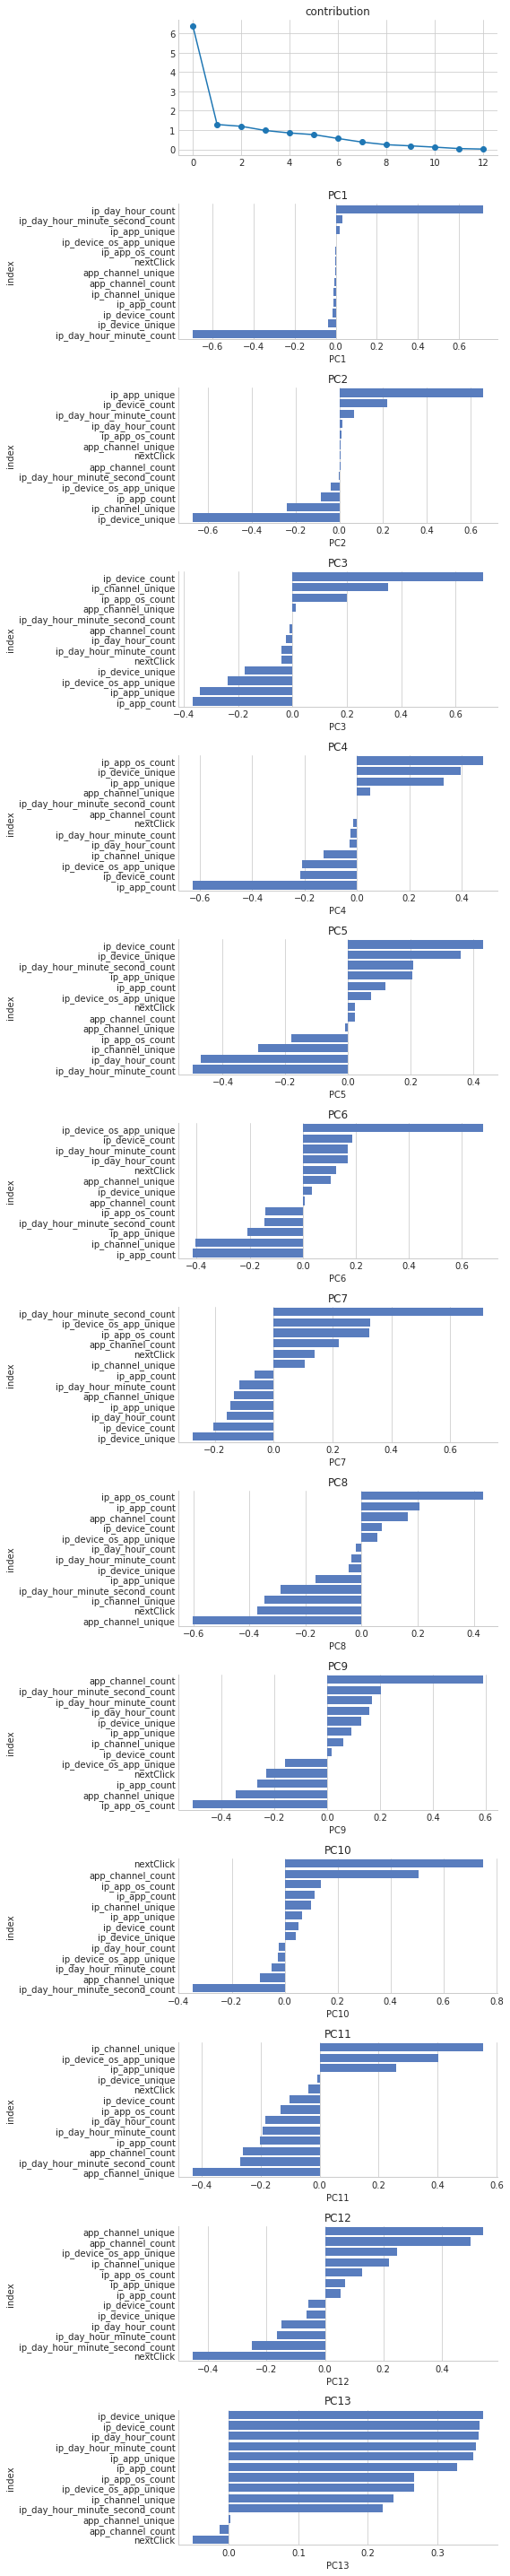

In [14]:
fig, axs = plt.subplots(nrows=14, ncols=1, figsize=(8, 40))

axs[0].plot(eigval, 'o-')
axs[0].set_title('contribution')

for i, ax in enumerate(axs[1:]):
    pc = f'PC{i + 1}'
    sns.set_color_codes('muted')
    sns.barplot(
        data=pd.DataFrame(
            eigvec[:, ::-1][:, i], columns=[pc], index=feature_names
        ).reset_index(level=0).sort_values(by=pc, ascending=False),
        x=pc, y='index',
        color='b',
        ax=ax
    )
    sns.despine(right=True)
    ax.set_title(pc);
    
plt.tight_layout()

In [15]:
train = pd.read_hdf('../input/X_train_add_supplement.h5', 'table')
test  = pd.read_hdf('../input/X_test_add_supplement.h5',  'table')

In [18]:
train.fillna(0, inplace=True)
test.fillna( 0, inplace=True)

In [19]:
n_components = 3

train_pc = ((train[feature_names].values - mean) / std) @ eigvec[:, :n_components]
test_pc  = ((test[ feature_names].values - mean) / std) @ eigvec[:, :n_components]

In [28]:
for pc_i in range(0, n_components):
    pc = f'PC{pc_i + 1}'
    train[pc] = train_pc[:, pc_i]
    test[ pc] = test_pc[ :, pc_i]

In [ ]:
train.to_hdf('../input/X_train_pc.h5', 'table')
test.to_hdf( '../input/X_test_pc.h5',  'table')